In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
!pip install tqdm
from tqdm import tqdm
from torchsummary import summary
import sys
import os

from model import *
from utils import *

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
use_cuda = torch.cuda.is_available()
device = get_device()

cpu


In [3]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms())
# The dataset named "MNIST" is being called from within the torchvision available datasets
# MNIST is a dataset containing handwritten digits
# The training part of the dataset is downloaded to ../data location
# This is also the Extract (E) part of the ETL process where we are going to extract the dataset from raw data
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms())
# The test part of the dataset is downloaded to ../data location

torch.manual_seed(1)
batch_size = 32
# Batch Size is a tunable parameter that tells us how many images can be sent in parallel to the model. 
# This depends on the available memory and can be increased/decreased accordingly. This is tuned after the model is ran and based on available memory
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
# trainloader is sort of "for" loop for us which will allow to look at or load a lot of images (~batch_size) at same time
# torch.utils.data.DataLoader wraps a dataset and provides access to the underlying data
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
# test till help to check accuracy of our model


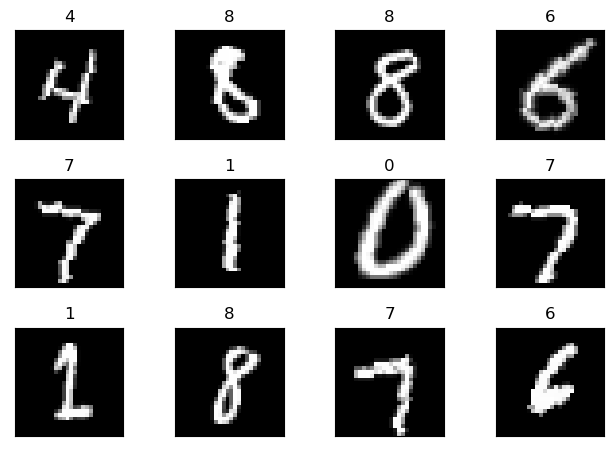

In [4]:
return_dataset_images(train_loader,12)

In [5]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def train(model, device, train_loader, optimizer):
  model.train()
  # here we are using the train component of the model
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # here above we are looping through each batch represented by batch id (like 4th batch, 5th batch, etc) and data is images of batch and target is the label  
    data, target = data.to(device), target.to(device)
    # since model is being trained on GPU, we need to send data and targets also to GPU. They can't be on CPU
    optimizer.zero_grad()
    # When we do back propagation, the gradients will be stored at one place and we need to initiate gradients as zero to begin withwhich is done in this step
    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    # Computing loss using negative likelyhood loss function. Comparision is made between predicted output with targets
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    # The loss is sent to backpropagation and here the gradients are computed based on the loss
    optimizer.step()
    # Applying the gradients to the parameters
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))


def test(model, device, test_loader):
    model.eval()
    # here we are involking the evaluation method of the model object
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # Here we are looping through the images and labels in the test dataset
            data, target = data.to(device), target.to(device)
            # since model is being trained on GPU, we need to send data and targets also to GPU. They can't be on CPU
            output = model(data)
            # we are sending model output to output variable
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            # Computing loss using negative likelyhood loss function. Comparision is made between predicted output with targets
            # We are also summing up batch loss
            correct += GetCorrectPredCount(output, target)
            # Summing up the correct predictions

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [6]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           1,664
              ReLU-2           [-1, 64, 24, 24]               0
       BatchNorm2d-3           [-1, 64, 24, 24]             128
           Dropout-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
            Conv2d-6           [-1, 32, 12, 12]           2,080
            Conv2d-7           [-1, 32, 10, 10]           9,248
              ReLU-8           [-1, 32, 10, 10]               0
       BatchNorm2d-9           [-1, 32, 10, 10]              64
           Conv2d-10           [-1, 10, 10, 10]             330
           Conv2d-11             [-1, 10, 6, 6]           2,510
             ReLU-12             [-1, 10, 6, 6]               0
      BatchNorm2d-13             [-1, 10, 6, 6]              20
        MaxPool2d-14             [-1, 1

In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)

num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0331 Batch_id=1874 Accuracy=95.68: 100%|██████████| 1875/1875 [01:20<00:00, 23.39it/s]


Test set: Average loss: 0.0367, Accuracy: 9883/10000 (98.83%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1604 Batch_id=1874 Accuracy=97.85: 100%|██████████| 1875/1875 [01:30<00:00, 20.82it/s]


Test set: Average loss: 0.0351, Accuracy: 9881/10000 (98.81%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0811 Batch_id=1874 Accuracy=98.30: 100%|██████████| 1875/1875 [01:28<00:00, 21.13it/s]


Test set: Average loss: 0.0307, Accuracy: 9903/10000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0085 Batch_id=1874 Accuracy=98.32: 100%|██████████| 1875/1875 [01:39<00:00, 18.88it/s]


Test set: Average loss: 0.0257, Accuracy: 9915/10000 (99.15%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0237 Batch_id=1874 Accuracy=98.63: 100%|██████████| 1875/1875 [01:25<00:00, 21.93it/s]


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6


Train: Loss=0.0809 Batch_id=1874 Accuracy=98.94: 100%|██████████| 1875/1875 [01:36<00:00, 19.36it/s]


Test set: Average loss: 0.0185, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.0004 Batch_id=1874 Accuracy=99.02: 100%|██████████| 1875/1875 [01:25<00:00, 22.01it/s]


Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.0127 Batch_id=1874 Accuracy=99.06: 100%|██████████| 1875/1875 [01:10<00:00, 26.56it/s]


Test set: Average loss: 0.0181, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.0091 Batch_id=1874 Accuracy=99.02: 100%|██████████| 1875/1875 [01:10<00:00, 26.75it/s]


Test set: Average loss: 0.0174, Accuracy: 9949/10000 (99.49%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.0157 Batch_id=1874 Accuracy=99.10: 100%|██████████| 1875/1875 [01:14<00:00, 25.06it/s]


Test set: Average loss: 0.0174, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 11


Train: Loss=0.0006 Batch_id=1874 Accuracy=99.11: 100%|██████████| 1875/1875 [01:12<00:00, 25.87it/s]


Test set: Average loss: 0.0174, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 12


Train: Loss=0.0098 Batch_id=1874 Accuracy=99.11: 100%|██████████| 1875/1875 [01:11<00:00, 26.36it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13


Train: Loss=0.0087 Batch_id=1874 Accuracy=99.11: 100%|██████████| 1875/1875 [01:11<00:00, 26.39it/s]


Test set: Average loss: 0.0171, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 14


Train: Loss=0.0209 Batch_id=1874 Accuracy=99.12: 100%|██████████| 1875/1875 [01:09<00:00, 27.12it/s]


Test set: Average loss: 0.0171, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15


Train: Loss=0.0311 Batch_id=1874 Accuracy=99.11: 100%|██████████| 1875/1875 [01:11<00:00, 26.37it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 16


Train: Loss=0.0218 Batch_id=1874 Accuracy=99.12: 100%|██████████| 1875/1875 [01:09<00:00, 27.06it/s]


Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 17


Train: Loss=0.0439 Batch_id=1874 Accuracy=99.09: 100%|██████████| 1875/1875 [01:10<00:00, 26.69it/s]


Test set: Average loss: 0.0171, Accuracy: 9947/10000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 18


Train: Loss=0.0033 Batch_id=1874 Accuracy=99.08: 100%|██████████| 1875/1875 [01:09<00:00, 27.03it/s]


Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 19


Train: Loss=0.0152 Batch_id=1874 Accuracy=99.10: 100%|██████████| 1875/1875 [01:10<00:00, 26.71it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 20


Train: Loss=0.0060 Batch_id=1874 Accuracy=99.07: 100%|██████████| 1875/1875 [01:08<00:00, 27.31it/s]


Test set: Average loss: 0.0171, Accuracy: 9947/10000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-06.


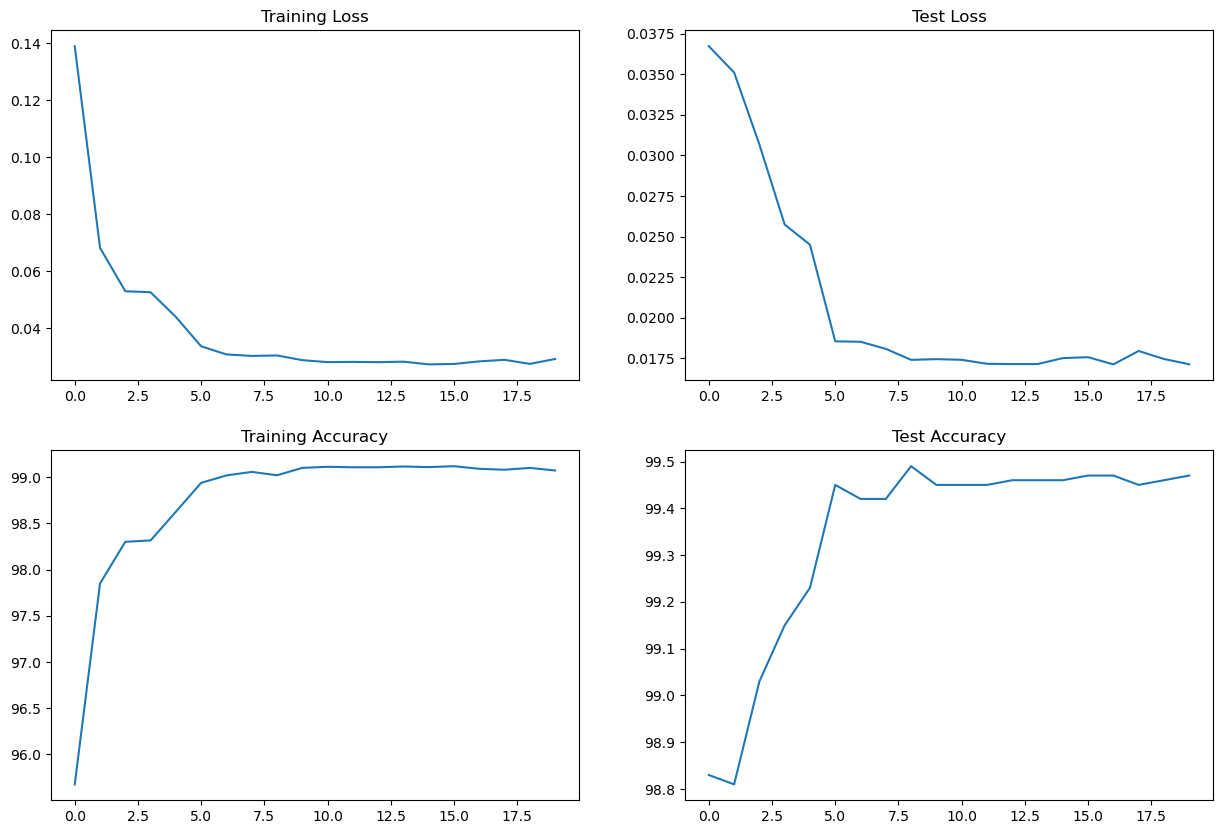

In [8]:
draw_graphs(train_losses, train_acc, test_losses, test_acc)